In [2]:
import os, torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch import optim
from torchsummary import summary

In [3]:
# 確定使用 CPU or Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset
class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames    # 資料集的所有檔名
        self.labels = labels          # 影像的標籤
        self.transform = transform    # 影像的轉換方式
 
    def __len__(self):
        return len(self.filenames)    # return DataSet 長度
 
    def __getitem__(self, idx):       # idx: Inedx of filenames
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image
        label = np.array(self.labels[idx])
        return image, label           # return 模型訓練所需的資訊

In [6]:
train_transformer = transforms.Compose([
    transforms.Resize(256), # 將圖像大小調整到256x256像素
    transforms.CenterCrop(224), # 從圖像中心裁剪出224x224像素的區域
    transforms.ToTensor(), # 圖像轉換成PyTorch的Tensor
    # 標準化處理 mean 代表平均值 std 代表標準差 利用每個通道的像素減去相應的均值除以標準差 可使像素值分佈接近標準正態分佈
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# 參數設定
batch_size = 32                                  # Batch Size
lr = 1e-3                                        # Learning Rate
epochs = 10                                      # epoch 次數

data_dir = 'train'                               # 資料夾名稱

In [14]:
def split_Train_Val_Data(data_dir):
    dataset = ImageFolder(data_dir)
    # 建立 20 類的 list
    character = [[] for i in range(len(dataset.classes))]
    
    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:
        character[y].append(x)
      
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        np.random.seed(42)
        np.random.shuffle(data)
            
        # -------------------------------------------
        # 將每一類都以 8:2 的比例分成訓練資料和測試資料
        # -------------------------------------------
        num_sample_train = int(len(data) * 0.8)
        num_sample_test = len(data) - num_sample_train
        print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))
        
        for x in data[:num_sample_train] : # 前 80% 資料存進 training list
            train_inputs.append(x)
            train_labels.append(i)
            
        for x in data[num_sample_train:] : # 後 20% 資料存進 testing list
            test_inputs.append(x)
            test_labels.append(i)

    train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                  batch_size = batch_size, shuffle = False)
    return train_dataloader, test_dataloader

In [15]:
train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)
C = models.vgg16(pretrained=True).to(device)     # 使用內建的 model 
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer
summary(C, (3, 244, 244))                        # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)
# Loss function
criterion = nn.CrossEntropyLoss()                # 選擇想用的 loss function

0: 105 | 84 | 21
1: 123 | 98 | 25
2: 147 | 117 | 30
3: 107 | 85 | 22
4: 108 | 86 | 22
5: 114 | 91 | 23
6: 129 | 103 | 26
7: 93 | 74 | 19
8: 109 | 87 | 22
9: 108 | 86 | 22
10: 78 | 62 | 16
11: 103 | 82 | 21
12: 149 | 119 | 30
13: 148 | 118 | 30
14: 81 | 64 | 17
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1,

In [16]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

In [17]:
import time


if __name__ == '__main__':    
    for epoch in range(epochs):
        start_time = time.time()
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        for i, (x, label) in enumerate(train_dataloader) :
            x, label = x.to(device), label.to(device)
            optimizer_C.zero_grad()                         # 清空梯度
            train_output = C(x)                             # 將訓練資料輸入至模型進行訓練 (Forward propagation)
            train_loss = criterion(train_output, label)     # 計算 loss
            train_loss.backward()                           # 將 loss 反向傳播
            optimizer_C.step()                              # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(train_output.data, 1)  # 取出預測的 maximum
            total_train += label.size(0)
            correct_train += (predicted == label).sum()
            train_loss_C += train_loss.item()
            iter += 1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))
        
        # --------------------------
        # Testing Stage
        # --------------------------
        C.eval() # 設定 train 或 eval
        for i, (x, label) in enumerate(test_dataloader) :
            with torch.no_grad():                           # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                test_output = C(x)                          # 將測試資料輸入至模型進行測試
                test_loss = criterion(test_output, label)   # 計算 loss
                
                # 計算測試資料的準確度 (correct_test / total_test)
                _, predicted = torch.max(test_output.data, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * (correct_train / total_train).cpu()) # training accuracy
        test_acc.append(100 * (correct_test / total_test).cpu())    # testing accuracy
        loss_epoch_C.append((train_loss_C / iter))            # loss 

        end_time = time.time()
        print('Cost %.3f(secs)' % (end_time - start_time))

epoch: 1 / 10
Training epoch: 1 / loss_C: 5.858 | acc: 0.074
Testing acc: 0.223
Cost 14.625(secs)
epoch: 2 / 10
Training epoch: 2 / loss_C: 2.783 | acc: 0.296
Testing acc: 0.405
Cost 14.077(secs)
epoch: 3 / 10
Training epoch: 3 / loss_C: 1.779 | acc: 0.482
Testing acc: 0.564
Cost 13.441(secs)
epoch: 4 / 10
Training epoch: 4 / loss_C: 1.182 | acc: 0.626
Testing acc: 0.740
Cost 13.467(secs)
epoch: 5 / 10
Training epoch: 5 / loss_C: 0.803 | acc: 0.750
Testing acc: 0.734
Cost 14.905(secs)
epoch: 6 / 10
Training epoch: 6 / loss_C: 0.641 | acc: 0.794
Testing acc: 0.801
Cost 14.693(secs)
epoch: 7 / 10
Training epoch: 7 / loss_C: 0.498 | acc: 0.838
Testing acc: 0.821
Cost 14.935(secs)
epoch: 8 / 10
Training epoch: 8 / loss_C: 0.391 | acc: 0.871
Testing acc: 0.850
Cost 14.405(secs)
epoch: 9 / 10
Training epoch: 9 / loss_C: 0.314 | acc: 0.890
Testing acc: 0.847
Cost 13.454(secs)
epoch: 10 / 10
Training epoch: 10 / loss_C: 0.292 | acc: 0.911
Testing acc: 0.841
Cost 13.699(secs)


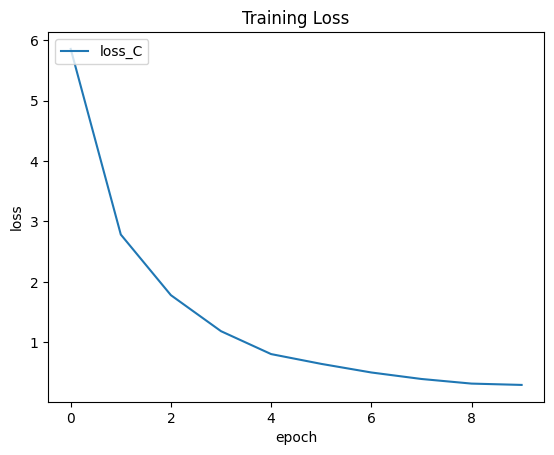

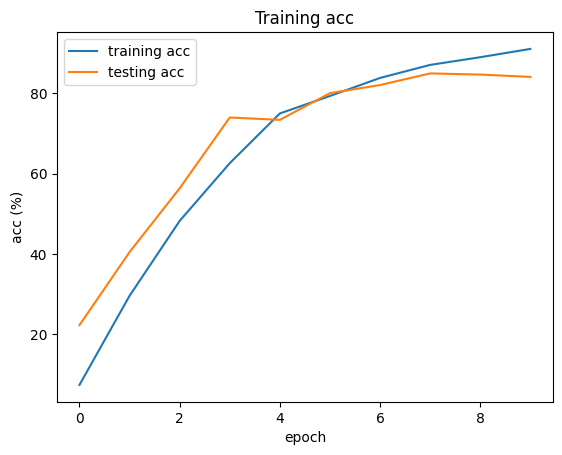

In [18]:
fig_dir = './fig/'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

plt.figure()
plt.plot(list(range(epochs)), loss_epoch_C) # plot your loss
plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.savefig(os.path.join(fig_dir, 'loss.png'))
plt.show()

plt.figure()
plt.plot(list(range(epochs)), train_acc)    # plot your training accuracy
plt.plot(list(range(epochs)), test_acc)     # plot your testing accuracy
plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig(os.path.join(fig_dir, 'acc.png'))
plt.show()